In [1]:
import cv2
import numpy as np
import os
from skimage import exposure, restoration
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from scipy.stats import kurtosis, skew
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
DATA_PATH = 'RetinalOCT_Dataset/RetinalOCT_Dataset'

def load_image(split, limit=50):
    images = []
    labels = []
    split_path = os.path.join(DATA_PATH, split)
    
    for i, folder in enumerate(os.listdir(split_path)):
        folder_path = os.path.join(split_path, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            img = cv2.imread(file_path)
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
            images.append(img)
            labels.append(i)

    return np.array(images), np.array(labels)

train_img_raw, Y_train = load_image('train')
val_img_raw, Y_val = load_image('val')
test_img_raw, Y_test = load_image('test')


In [3]:
def preprocess_oct(image):
    # 1. Denoising: bilateral filter lebih halus untuk struktur retina
    denoised = cv2.bilateralFilter(image, 9, 75, 75)
    
    # 2. Kontras lokal pakai CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)
    
    # 3. Normalisasi z-score (lebih stabil dari min-max)
    norm = (enhanced - np.mean(enhanced)) / (np.std(enhanced) + 1e-8)
    
    return norm


In [6]:
train_img_pre = np.array([preprocess_oct(img) for img in train_img_raw])
val_img_pre   = np.array([preprocess_oct(img) for img in val_img_raw])
test_img_pre  = np.array([preprocess_oct(img) for img in test_img_raw])

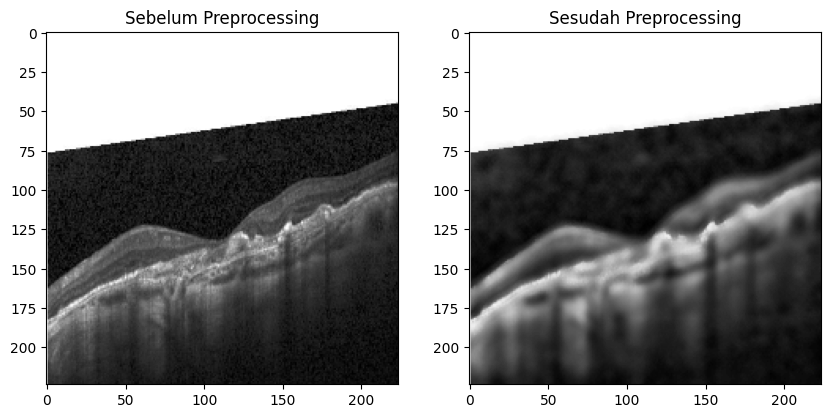

In [7]:
import matplotlib.pyplot as plt

idx = 49  # contoh index gambar
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(train_img_raw[idx], cmap='gray')
plt.title('Sebelum Preprocessing')

plt.subplot(1,2,2)
plt.imshow(train_img_pre[idx], cmap='gray')
plt.title('Sesudah Preprocessing')

plt.show()


In [8]:
LBP_RADIUS = 2
LBP_POINTS = 8 * LBP_RADIUS
GABOR_THETAS = np.arange(0, np.pi, np.pi / 4)

In [9]:
def extract_features(img):
    features = []

    # ---- Statistik dasar ----
    features.extend([
        np.mean(img),
        np.std(img),
        skew(img.ravel()),
        kurtosis(img.ravel()),
        np.percentile(img, 10),
        np.percentile(img, 50),
        np.percentile(img, 90)
    ])

    # ---- Sobel & edge ----
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    features.extend([np.mean(grad_mag), np.std(grad_mag)])

    edges = cv2.Canny((img * 255).astype(np.uint8), 50, 150)
    edge_density = np.sum(edges > 0) / edges.size
    features.append(edge_density)

    # ---- LBP ----
    lbp = local_binary_pattern((img * 255).astype(np.uint8), LBP_POINTS, LBP_RADIUS, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=LBP_POINTS + 2, range=(0, LBP_POINTS + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-8)
    features.extend(hist)

    # ---- GLCM (Gray-Level Co-Occurrence Matrix) ----
    glcm = graycomatrix((img * 255).astype(np.uint8), distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    props = ['contrast', 'correlation', 'energy', 'homogeneity']
    for p in props:
        features.extend(graycoprops(glcm, p).flatten())

    # ---- Gabor filter bank ----
    for theta in GABOR_THETAS:
        kernel = cv2.getGaborKernel((15, 15), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
        features.extend([np.mean(fimg), np.std(fimg)])

    return np.array(features)

In [10]:
def extract_features_batch(images):    
    features = []
    total = len(images)
    
    for i, img in enumerate(images, 1):
        feature = extract_features(img)
        features.append(feature)

        if i % (total//10) == 0:
            percentage = int((i / total) * 100)
            print(f"==> {percentage}% done ({i}/{total} images)\n")
    
    print("Features Extraction Completed\n")
    return np.vstack(features)

In [11]:
X_train = extract_features_batch(train_img_pre)
X_val = extract_features_batch(val_img_pre)
X_test = extract_features_batch(test_img_pre)

==> 10% done (1840/18400 images)

==> 20% done (3680/18400 images)

==> 30% done (5520/18400 images)

==> 40% done (7360/18400 images)

==> 50% done (9200/18400 images)

==> 60% done (11040/18400 images)

==> 70% done (12880/18400 images)

==> 80% done (14720/18400 images)

==> 90% done (16560/18400 images)

==> 100% done (18400/18400 images)

Features Extraction Completed

==> 10% done (280/2800 images)

==> 20% done (560/2800 images)

==> 30% done (840/2800 images)

==> 40% done (1120/2800 images)

==> 50% done (1400/2800 images)

==> 60% done (1680/2800 images)

==> 70% done (1960/2800 images)

==> 80% done (2240/2800 images)

==> 90% done (2520/2800 images)

==> 100% done (2800/2800 images)

Features Extraction Completed

==> 10% done (280/2800 images)

==> 20% done (560/2800 images)

==> 30% done (840/2800 images)

==> 40% done (1120/2800 images)

==> 50% done (1400/2800 images)

==> 60% done (1680/2800 images)

==> 70% done (1960/2800 images)

==> 80% done (2240/2800 images)

==>

In [13]:
import pickle
with open('image_features.pkl', 'wb') as file:
    pickle.dump({
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test
    }, file)

with open('image_features.pkl', 'rb') as file:
    data = pickle.load(file)

X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# SVM

In [ ]:
# di comment
svm = SVC(class_weight='balanced', random_state=42)

In [ ]:
# di comment
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,               # 5-fold cross validation
    n_jobs=-1,          # gunakan semua core CPU
    verbose=2,
    scoring='accuracy'
)

In [ ]:
# di comment
grid.fit(X_train_scaled, Y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.4s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   4.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   9.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   9.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  10.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   6.8s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   7.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   7.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  10.2s
[CV] END ...................

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=2)

In [ ]:
# di comment
print(grid.best_estimator_)

SVC(C=100, class_weight='balanced', gamma=0.01, random_state=42)


In [ ]:
# di comment
best_svm = grid.best_estimator_

In [18]:
# biar ga usah tunning lagi, nanti comment aja code tunningnya langsung run bagian ini

best_svm = SVC(
    C=100,
    gamma=0.01,
    kernel='rbf',          # kernel default hasil GridSearch jika kamu tidak ubah
    class_weight='balanced',
    random_state=42
)

best_svm.fit(X_train_scaled, Y_train)

SVC(C=100, class_weight='balanced', gamma=0.01, random_state=42)

In [21]:
with open('best_svm_model.pkl', 'wb') as file:
    pickle.dump(best_svm, file)
with open('best_svm_model.pkl', 'rb') as file:
    best_svm = pickle.load(file)

In [19]:
classes = ['AMD','CNV','CSR','DME','DR','DRUSEN','MH','NORMAL']

In [20]:
y_val_pred_svm = best_svm.predict(X_val_scaled)
y_test_pred_svm = best_svm.predict(X_test_scaled)

print("\nValidation Accuracy:", accuracy_score(Y_val, y_val_pred_svm))
print("Test Accuracy:", accuracy_score(Y_test, y_test_pred_svm))

print("\nClassification Report (Validation):")
print(classification_report(Y_val, y_val_pred_svm, target_names=classes))

print("\nClassification Report (Test):")
print(classification_report(Y_test, y_test_pred_svm, target_names=classes))

print("\nConfusion Matrix (Validation):")
print(confusion_matrix(Y_val, y_val_pred_svm))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(Y_test, y_test_pred_svm))


Validation Accuracy: 0.75
Test Accuracy: 0.7410714285714286

Classification Report (Validation):
              precision    recall  f1-score   support

         AMD       0.68      0.77      0.72       350
         CNV       0.83      0.83      0.83       350
         CSR       0.84      0.84      0.84       350
         DME       0.92      0.92      0.92       350
          DR       0.58      0.51      0.54       350
      DRUSEN       1.00      1.00      1.00       350
          MH       0.53      0.50      0.51       350
      NORMAL       0.60      0.63      0.62       350

    accuracy                           0.75      2800
   macro avg       0.75      0.75      0.75      2800
weighted avg       0.75      0.75      0.75      2800


Classification Report (Test):
              precision    recall  f1-score   support

         AMD       0.65      0.66      0.66       350
         CNV       0.83      0.87      0.85       350
         CSR       0.87      0.83      0.85       350
   

# Random Forest

In [28]:
rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

In [29]:
param_grid = {
    'n_estimators': [100, 200, 300],         # jumlah pohon
    'max_depth': [None, 10, 20, 30],         # kedalaman maksimum tiap pohon
    'min_samples_split': [2, 5, 10],         # minimal sample untuk split
    'min_samples_leaf': [1, 2, 4],           # minimal sample di daun
    'max_features': ['sqrt', 'log2', None]   # jumlah fitur per split
}

In [30]:
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                    # 5-fold cross validation
    n_jobs=-1,               # gunakan semua core
    verbose=2,
    scoring='accuracy'       # bisa diganti 'f1_macro' untuk dataset tidak seimbang
)

In [ ]:
grid_rf.fit(X_train, Y_train)

In [32]:
print("Best Parameters:", grid_rf.best_params_)
print("Best Cross-Validation Accuracy:", grid_rf.best_score_)

Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation Accuracy: 0.6779891304347826


In [33]:
best_rf = grid_rf.best_estimator_

In [34]:
y_val_pred_rf = best_rf.predict(X_val)
y_test_pred_rf = best_rf.predict(X_test_scaled)

print("\nValidation Accuracy:", accuracy_score(Y_val, y_val_pred_rf))
print("Test Accuracy:", accuracy_score(Y_test, y_test_pred_rf))

print("\nClassification Report (Validation):")
print(classification_report(Y_val, y_val_pred_rf, target_names=classes))

print("\nClassification Report (Test):")
print(classification_report(Y_test, y_test_pred_rf, target_names=classes))

print("\nConfusion Matrix (Validation):")
print(confusion_matrix(Y_val, y_val_pred_rf))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(Y_test, y_test_pred_rf))


Validation Accuracy: 0.6892857142857143
Test Accuracy: 0.33785714285714286

Classification Report (Validation):
              precision    recall  f1-score   support

         AMD       0.62      0.68      0.65       350
         CNV       0.80      0.81      0.81       350
         CSR       0.81      0.76      0.78       350
         DME       0.83      0.91      0.87       350
          DR       0.50      0.43      0.46       350
      DRUSEN       0.99      1.00      1.00       350
          MH       0.44      0.45      0.45       350
      NORMAL       0.49      0.47      0.48       350

    accuracy                           0.69      2800
   macro avg       0.69      0.69      0.69      2800
weighted avg       0.69      0.69      0.69      2800


Classification Report (Test):
              precision    recall  f1-score   support

         AMD       0.29      0.35      0.32       350
         CNV       0.36      0.67      0.47       350
         CSR       0.33      0.05      0.0

# MLP

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [65]:
Y_train_enc = to_categorical(Y_train)
Y_val_enc = to_categorical(Y_val)
Y_test_enc = to_categorical(Y_test)

In [66]:
n_features = X_train.shape[1]
n_classes = Y_train_enc.shape[1]

In [ ]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()

    # Hidden layer 1
    model.add(Dense(
        units=hp.Int('units1', min_value=64, max_value=512, step=64),
        activation='relu',
        input_shape=(X_train_scaled.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))

    # Hidden layer 2
    model.add(Dense(
        units=hp.Int('units2', min_value=32, max_value=256, step=32),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1)))

    # Hidden layer 3
    model.add(Dense(
        units=hp.Int('units3', min_value=16, max_value=256, step=32),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout3', 0.2, 0.5, step=0.1)))

    # Output layer (jumlah neuron = jumlah kelas)
    model.add(Dense(Y_train_enc.shape[1], activation='softmax'))

    # Gunakan categorical_crossentropy karena label sudah one-hot
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Inisialisasi tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=8,
    executions_per_trial=1,
    directory='tuner_dir_bn',
    project_name='mlp_bn_test'
)

# Jalankan tuning
tuner.search(
    X_train_scaled, Y_train_enc,
    epochs=20,
    validation_data=(X_val_scaled, Y_val_enc),
    batch_size=32,
    verbose=1
)

# Ambil hyperparameter terbaik
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Bangun ulang model terbaik
best_mlp = build_model(best_hp)

# Callback untuk early stopping dan simpan model terbaik
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_mlp_bn_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Latih ulang model terbaik
history = best_mlp.fit(
    X_train_scaled, Y_train_enc,
    validation_data=(X_val_scaled, Y_val_enc),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Evaluasi model terbaik
loss, acc = best_mlp.evaluate(X_val_scaled, Y_val_enc, verbose=0)
print(f"\n✅ Best Model Validation Accuracy (retrained): {acc:.4f}")

best_mlp.summary()

# Tampilkan semua hyperparameter terbaik
print("\n🔍 Best Hyperparameters:")
for k, v in best_hp.values.items():
    print(f"{k}: {v}") 

Trial 8 Complete [00h 00m 13s]
val_accuracy: 0.7028571367263794

Best val_accuracy So Far: 0.7325000166893005
Total elapsed time: 00h 01m 43s
Epoch 1/30
527/575 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.4213 - loss: 1.5840
Epoch 1: val_accuracy improved from None to 0.60250, saving model to best_mlp_bn_model.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4842 - loss: 1.2737 - val_accuracy: 0.6025 - val_loss: 0.8992
Epoch 2/30
537/575 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.5596 - loss: 0.9881
Epoch 2: val_accuracy improved from 0.60250 to 0.64000, saving model to best_mlp_bn_model.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.5738 - loss: 0.9588 - val_accuracy: 0.6400 - val_loss: 0.8140
Epoch 3/30
542/575 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.5938 - loss: 0.9146
Epoch 3: val_accuracy improved from 0.64000 to 0.65893, saving model to best_mlp_bn_model.keras
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.6057 - loss: 0.8

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 320)            │        16,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 160)            │        51,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 160)            │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 80)             │        12,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           648 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,026 (976.67 KB)

 Trainable params: 82,968 (324.09 KB)

 Non-trainable params: 1,120 (4.38 KB)

 Optimizer params: 165,938 (648.20 KB)


🔍 Best Hyperparameters:
units1: 320
dropout1: 0.2
units2: 160
dropout2: 0.30000000000000004
units3: 80
dropout3: 0.4
learning_rate: 0.001
  - Learning Rate       : 0.001
